## HW2
#### Due Mar. 18th by end of day. Name your notebook as firstname.lastname.HW2.ipynb and email it to zhang@csc.lsu.edu

Your tasks in this homework are to experiment with CNN.
A simple CNN is given below. 

### Task 1
Train the CNN (as much as you can) to reach convergence. Investigate what patterns the first layer (layer 0) filters pick up by plotting the filters as small 2d images. To plot a 2d array x as image, use "imshow(x, cmap=cm.gray)". You should plot the 10 filters together using subplot. 

### Task 2
The given CNN has 2 conv&pool layers, 1 hidden layer and 1 output layer. 
Modify the CNN to have:
  - 1 conv&pool layer, 1 hidden layer and 1 output layer;
  - 1 hidden layer and 1 output layer; 
  
while keeping the other parameters the same. Compare the error rates on the test data for the original CNN and the two modifications and determine whether the conv&pool layers play a significant role for performance.

### Task 3
Change the number of filters for the two conv&pool layers:
  - try 10 filters for layer 1 and 20 for layer 2;
  - try 20 filters for layer 1 and 10 for layer 2.

Compare error rate of the two cases and that of the original. Comment on how number of filters can impact performance. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import cPickle, gzip

import numpy

import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv

## Hidden Layer and Output Layer

In [2]:
class HiddenLayer(object):

    def __init__(self, input, n_in, n_out):
        self.input = input

        W_values = 4*numpy.random.uniform(
                low=-numpy.sqrt(6. / (n_in + n_out)),
                high=numpy.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        self.W = theano.shared(value=W_values, name='W', borrow=True)
        self.b = theano.shared(value=numpy.zeros((n_out,)), name='b', borrow=True)
        self.params = [self.W, self.b]

        net = T.dot(self.input, self.W) + self.b
        self.output = T.nnet.sigmoid(net)

        
class MultiLogisticRegression(object):

    def __init__(self, input, n_in, n_out):

        self.input = input

        self.W = theano.shared(
            value=numpy.zeros((n_in, n_out)),
            name='W',
            borrow=True
        )
        self.b = theano.shared(
            value = numpy.zeros((n_out,)),
            name='b',
            borrow=True
        )
        self.params = [self.W, self.b]

        self.prob = T.nnet.softmax(T.dot(self.input, self.W) + self.b)
        self.predict = T.argmax(self.prob, axis=1)

    def nll(self, y):
        return  -T.mean(T.log(self.prob)[T.arange(y.shape[0]), y])


## Conv + Pool Layer
### output size = (imagesize - filtersize + 1)/poolsize

In [3]:
class ConvPoolLayer(object):

    def __init__(self, input, filter_shape, image_shape, poolsize):

        self.input = input

        n_in = filter_shape[1]*filter_shape[2]*filter_shape[3]
        n_out = (filter_shape[0]*filter_shape[2]*filter_shape[3])/(poolsize[0]*poolsize[1])
        W_bound = numpy.sqrt(6./(n_in + n_out))
        self.W = theano.shared(
            numpy.random.uniform(low=-W_bound, high=W_bound, size=filter_shape),
            borrow=True
        )
        self.b = theano.shared(value=numpy.zeros((filter_shape[0],)), borrow=True)
        self.params = [self.W, self.b]
        
        conv_out = conv.conv2d(
            input=self.input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape
        )

        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))


## Making ConvNN

In [4]:
batch_size = 250
learning_rate=0.1
nkerns=[10, 10]


x = T.matrix('x')
y = T.ivector('y')


layer0_input = x.reshape((batch_size, 1, 28, 28))
layer0 = ConvPoolLayer(
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 5, 5),
    poolsize=(2, 2)
)

layer1 = ConvPoolLayer(
    input=layer0.output,
    image_shape=(batch_size, nkerns[0], 12, 12),
    filter_shape=(nkerns[1], nkerns[0], 5, 5),
    poolsize=(2, 2)
)
layer1_output = layer1.output.flatten(2)

layer2 = HiddenLayer(
    input=layer1_output,
    n_in=nkerns[1]*4*4,
    n_out=50,
)

layer3 = MultiLogisticRegression(input=layer2.output, n_in=50, n_out=10)


cost = layer3.nll(y)


model_predict = theano.function(
    [x],
    layer3.predict
)


params = layer3.params + layer2.params + layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [x, y],
    cost,
    updates=updates
)

## Train and Test

In [5]:
dataset = 'digits.pkl.gz' 
f = gzip.open(dataset, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
train_set_x, train_set_y = train_set
test_set_x, test_set_y = test_set
train_set_y = train_set_y.astype(numpy.int32)

ix = []
for i in range(10):
    ix.append(numpy.nonzero(train_set_y == i)[0][:500])
ix = numpy.concatenate(ix)
train_set_x = train_set_x[ix]
train_set_y = train_set_y[ix]
ix = numpy.random.permutation(train_set_x.shape[0])
train_set_x = train_set_x[ix]
train_set_y = train_set_y[ix]

n_batches = train_set_x.shape[0]
n_batches /= batch_size

In [6]:
n_epochs = 200
c = numpy.zeros((n_epochs,))
for i in range(n_epochs): 
    err = 0
    for b in range(n_batches):
        err += train_model(train_set_x[b*batch_size:(b+1)*batch_size], train_set_y[b*batch_size:(b+1)*batch_size])
    print 'iteration:', i, ', nll =', err
    c[i] = err

iteration: 0 , nll = 45.1780980383
iteration: 1 , nll = 42.2615095687
iteration: 2 , nll = 37.8040743204
iteration: 3 , nll = 33.1011214281
iteration: 4 , nll = 29.0138154716
iteration: 5 , nll = 25.6802799256
iteration: 6 , nll = 23.0052467993
iteration: 7 , nll = 20.8391973134
iteration: 8 , nll = 19.0561584066
iteration: 9 , nll = 17.5590079206
iteration: 10 , nll = 16.283151117
iteration: 11 , nll = 15.1805239315
iteration: 12 , nll = 14.2154197146
iteration: 13 , nll = 13.3623298149
iteration: 14 , nll = 12.6024355814
iteration: 15 , nll = 11.9212642106
iteration: 16 , nll = 11.3069533892
iteration: 17 , nll = 10.751162823
iteration: 18 , nll = 10.2460590778
iteration: 19 , nll = 9.78226781244
iteration: 20 , nll = 9.35597807886
iteration: 21 , nll = 8.96396846219
iteration: 22 , nll = 8.60249229624
iteration: 23 , nll = 8.26728404315
iteration: 24 , nll = 7.95679097629
iteration: 25 , nll = 7.66767357431
iteration: 26 , nll = 7.3978538939
iteration: 27 , nll = 7.14582847725
itera

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


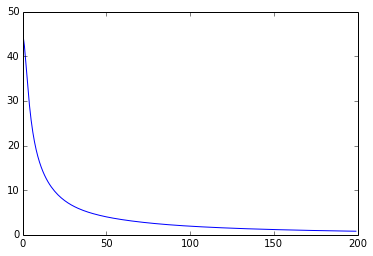

In [10]:
%pylab inline
plot(c)

In [11]:
n_testbatches = test_set_x.shape[0] / batch_size
err = 0
for b in range(n_testbatches):
    yp = model_predict(test_set_x[b*batch_size:(b+1)*batch_size])
    yy = test_set_y[b*batch_size:(b+1)*batch_size]
    err += len(np.nonzero(yp - yy)[0])

print 1.0*err/len(test_set_y)

0.0383
